# Appendix: Unsupervised Learning

Unsupervised learning differs from [supervised learning](supervised_learning) in that it uses unlabeled data.
Labeling data must usually be done manually by humans, and this can be both time-consuming and expensive.
On the other hand, the labels provide information for the machine learning algorithm to learn from.
Without labels, we can't do classification since there are no classes to learn.
Instead, unsupervised learning looks for patterns in the data itself.

The unsupervised alternative to classification is *clustering*, where we group similar items together in *clusters*.
Clustering also requires vectorizing the data to get a numeric representation that the computer can work with.
Unsupervised learning, like clustering, can be a good alternative when we lack the resources to label our data set.

## Visualizing Clustering

Like with classification, we can visualize clustering to see what's happening.
Again, we use a simple, simulated data set with only two features, so that the data can be plotted in a diagram.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
# configure matplotlib
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

Then, we use sklearn to make a simulated or synthetic data set.

In [2]:
data, _ = make_classification(n_features=2, n_redundant=0, n_informative=2,
                              random_state=2, n_clusters_per_class=1)

We can plot the unlabeled data points in a scatter plot.

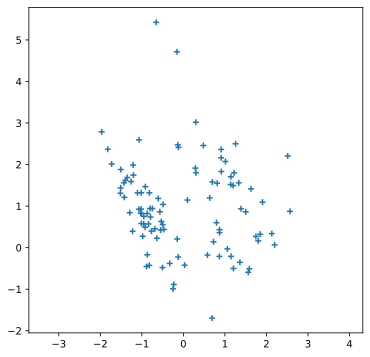

In [3]:
figure = plt.figure(figsize=(6, 6))
plt.axis('equal')
plt.scatter(data[:, 0], data[:, 1], marker='+');

Now, let's try to cluster the data with *k-means clustering*.
k-means clustering is a common clustering algorithm.
It takes the parameter *k*, which specifies the number of clusters we want to find.
In other words, we must know in advance how many clusters we wish to look for.
We can of course try different values for k, to see which works better.

In [4]:
Kmean = KMeans(n_clusters=2)
Kmean.fit(data)
clusters = Kmean.predict(data)

We can plot the results of the clustering.
What the algorithm learns is the mean or *center* of each cluster, which are displayed as blue dots on the plot.
Each data item is assigned to the cluster center which is closest to it.
The data points are colored according to their cluster.

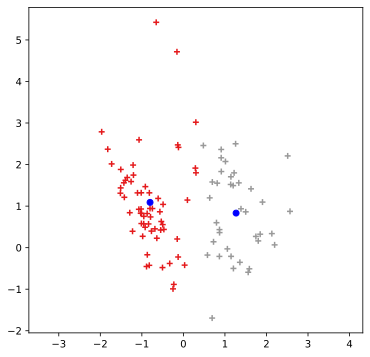

In [5]:
figure = plt.figure(figsize=(6, 6))
plt.axis('equal')
plt.scatter(data[:, 0], data[:, 1], c=clusters, marker='+', cmap=plt.cm.Set1)
for cluster_x, cluster_y in Kmean.cluster_centers_:
    plt.scatter(cluster_x, cluster_y, c='b')

## Clustering Text
We can cluster text as well.
The data preparation is much the same as we did when classifying texts.
However, this time we will use the somewhat more powerful `TfidfVectorizer` instead of `CountVectorizer`.

In [6]:
import json

def read_json_file(filename):
    'Read json data from a file'
    with open(filename, 'r') as file:
        text_data = file.read()
        return json.loads(text_data)


def json_to_text(doc, include_headings=True):
    '''
    Extract content text from JSON tree structure.
    https://echr-opendata.eu/doc/

    Params:
        doc: ECHR-OD JSON element
        include_headings: Whether to include the section headings
    '''
    def json_to_text_helper(doc):
        result = []
        if not doc['elements'] or include_headings:
            result.append(doc['content'].strip().replace('\xa0', ' '))  # replace non-breaking space
        for element in doc['elements']:
            result.extend(json_to_text_helper(element))
        return result
    return '\n'.join(json_to_text_helper(doc))


def get_facts(case):
    'Get the "Facts" section of the case text'
    content = case['content']
    docname = list(content)[0]
    document = content[docname]

    for section in document:
        if section.get('section_name') == 'facts':
            return json_to_text(section)
    return ''

As before , we read the json data from the file.

In [7]:
cases = read_json_file('cases-2000.json')

This time, there is only one list which contains the documents.

In [8]:
documents = [get_facts(case) for case in cases]

## Vectorizing Text

To use text documents in machine learning, they must first be vectorized.
We'll use a TF-IDF representation, which is provided by scikit-learn's `TfidfVectorizer()`.
This function has some parameters:
- `stop_words='english'` means that *function words* like "the" and "in" should be ignored.
Stop words carry little meaning, so it is often best to ignore them.
This is done by using a dictionary of English stop words to ignore.
- `lowercase=True` means that all words are converted to lowercase.
If we don't do this, all the words at the start of sentences with capital letters will be treated as separate words.

In [9]:
text_vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
)

```{admonition} TF-IDF representation
:class: dropdown
`TfidfVectorizer` uses *TF-IDF* representation.
TF is short for "term frequency", which is what `CountVectorizer` uses.
IDF is short for "inverse document frequency", and measures how rare a word is in all the texts.
A word that only occurs in a single document, is given more weight because it is probably more characteristic of that document.
```

With the vectorizer made, we can use it to transform the data:

In [10]:
input_features = text_vectorizer.fit_transform(documents)

Then we make the k-means clustering model.
We need to select a value for k.
If we don't know how many clusters to expect, we can just pick a number and see how that works.
We try with 10 clusters.

In [11]:
K = 10
kmeans = KMeans(n_clusters=K)

Then we use the model to do the clustering.

In [12]:
clusters = kmeans.fit_predict(input_features)

This method returns a list of cluster numbers, one for each document.
We can use this to list the clusters.
However, this is just a list of documents.
Instead, let's try to describe the clusters.
We can look at the terms that occur frequently in the cluster's documents.

## Labeling Clusters
Each cluster is represented by its center vector, which is called a centroid.
We can use this vector to find terms that have a high TF-IDF value.
These are terms that occur frequently in the documents in the cluster.

We can get the list of the terms (the dictionary) from the vectorizer.

In [13]:
terms = text_vectorizer.get_feature_names()

We can use the function `argsort()` to get a list of term indexes sorted from lowest to highest TF-IDF value.

In [14]:
top_terms_per_center = kmeans.cluster_centers_.argsort()

Then we reverse the order, to get the items with the highest TF-IDF values first.

In [15]:
top_terms_per_center = top_terms_per_center[:, ::-1]

Then, we make a list of the ten terms with the highest TF-IDF values for each cluster.
We do this by looking up the indexes in the term list.

In [16]:
for cluster in range(K):
    print(f'cluster {cluster}: ', end='')
    for index in top_terms_per_center[cluster, :10]:
        print(terms[index], end=' ')
    print()

cluster 0: tenant possession flat rents lease owner magistrate premises tenancies vacate 
cluster 1: prison applicant cell cells prisoners medical detention treatment court detainees 
cluster 2: applicants appended table details applications list complained set raised convention 
cluster 3: court applicant appeal proceedings district case hearing judgment decision hearings 
cluster 4: applicant detention court criminal trial appeal article prosecutor case remand 
cluster 5: applicant enforcement bailiffs court judgment debtor uah proceedings applicants company 
cluster 6: applicant court applicants article case law criminal mr act section 
cluster 7: land plot property applicants court applicant compensation decision expropriation ownership 
cluster 8: child children applicant court mother parents father custody family contact 
cluster 9: applicant police court officers prosecutor criminal investigation investigator statements officer 


Some of the terms aren't very informative.
For example, the term "applicant(s)" appearing all the lists, and other terms also appear in many of them.
We might get more informative labels by filtering out words that appear in more than two of the lists.


## Applying Unsupervised Learning

There are many possible applications for unsupervised learning.
The list below has only a few examples.

### Organizing Document Collections
Clustering is useful for organizing and navigating large document collections.
Small collections may be organized by hand, but organizing large collections manually might be infeasible.

### Search Result Diversification
Terms in search queries are often ambiguous.
For example, if someone searches for "properties law", do they mean "property law" or "properties of law", i.e. attributes of law?
Clustering of search results can be used to make sure that both meanings are reflected in the search results.

### Topic Modeling
Topic modeling is another unsupervised learning method, somewhat related to clustering.
The task is to discover a set of topics in a document collection.
These topics are then used to label and organize the documents.

### Visualizing Data
Clustering is a useful tool for visualizing patterns in data.
Another technique that might be necessary is *dimensionality reduction*.
This reduces the number of features or dimensions of a data set.
By extracting the most significant dimensions, the data can be visualized in 2 or 3 dimensions.